# A - Writing like shakespeare

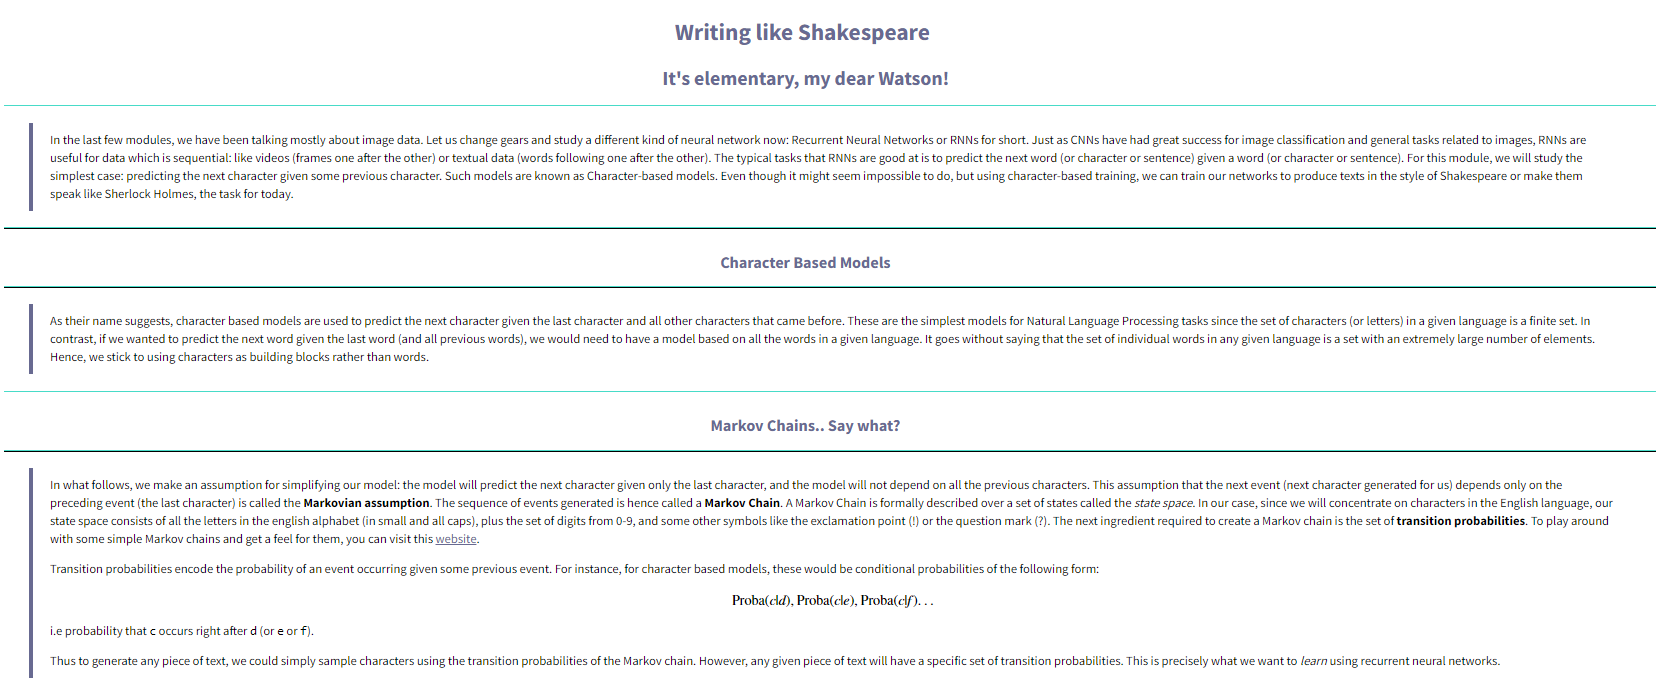

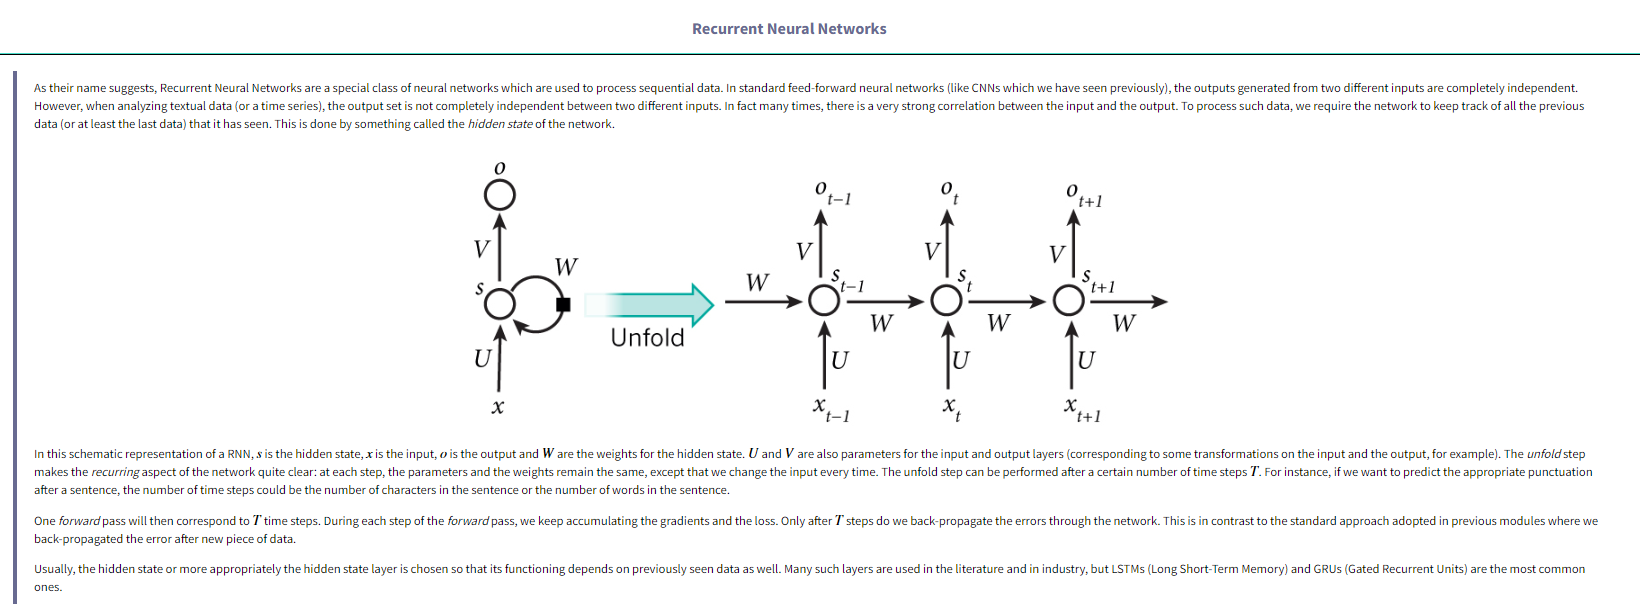

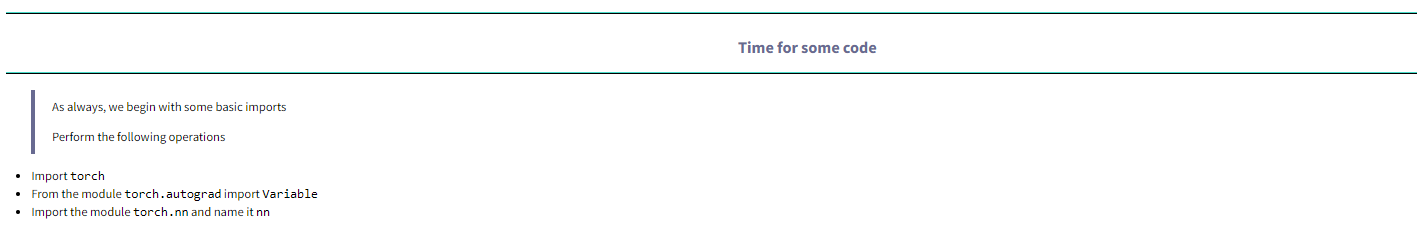

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn

The first step is to load the data. Two text files have been provided: holmes.txt and holmes_clean.txt. These are both available in the folder data. The two text files contain all the stories and novels based on the character Sherlock Holmes. The difference between the two files is that holmes_clean.txt contains only the actual text of the stories with all the other details like chapter names, table of contents removed.

Open the file holmes_clean.txt using the open function. This returns a file object. Name this object holmes_text
Read the contents of holmes_text and store the text in a variable all_text
Close holmes_text using the close function
Print the first 200 characters of all_text

In [ ]:
holmes_text = open('data/module_4/holmes_clean.txt', 'r')
all_text = holmes_text.read()
holmes_text.close()
print(all_text[:200])
# -> In the year 1878 I took my degree of Doctor of Medicine of the University of London, and proceeded to Netley to go through the course prescribed for surgeons in the army. Having completed my studies t

We will be using a character-based model. To that end, we require the complete list of possible ASCII characters that Python supports. These can be accessed using the string module.

Import the module string
Store the output of string.printable in a variable called all_chars
Store the number of these characters using the len function on all_chars in a variable n_chars
Print all_chars and n_chars

In [ ]:
import string 
all_chars = string.printable
n_chars = len(all_chars)
print(all_chars)
print(n_chars)
# -> 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

# -> 100


We note that all_chars contains all the letters of the english alphabet, with some other symbols and the digits from 0-9. It also contains the \n which is the new line character, the empty string '' and space " ".

Using the index function on all_chars print where the new-line, empty string and space characters occur in all_chars

In [ ]:
print(all_chars.index('\n'))
print(all_chars.index(''))
print(all_chars.index(" "))
# 96
# 0
# 94

## Transforming text to tensors 
PyTorch is a powerful library but even it has limits. We want to work on textual data, but PyTorch only understands numbers. To this end, we must convert every character in our corpus to a number. Which number? This number will be the index of the character in the variable all_chars. We will then store this index as a tensor, since PyTorch requires tensors.

Create a variable test_string and initialise it to 'abc'
Create a torch tensor of all zeros of size equal to the length of test_string. You can use the len function for this. Call this tensor test_tensor
Convert test_tensor to type long using the long() function on test_tensor. This has to be done inplace
   The transformation of the tensor to type long will become clear when we construct our neural network.

In [ ]:
test_string = 'abc'
test_tensor = torch.zeros(len(test_string))
test_tensor = test_tensor.long()

Remember that we can access the elements of the tensor via square brackets. For instance the first element of a tensor can be accessed as tensor[0].

Change the first element of test_tensor to the index corresponding to the letter 'a', first letter of the string test_string

In [ ]:
test_tensor[0] = all_chars.index(test_string[0])

Now that we can convert a single character to a number of type long, we can do this for any string by iterating over all characters in the string.

Iterate over all the characters in the string test_string and update the elements of test_tensor with the index corresponding to the characters in test_string. You can use the function len on test_string for iterating.
Print the elements of the test_tensor.

In [ ]:
for i in range(len(test_string)):
    test_tensor[i] = all_chars.index(test_string[i])
print(test_tensor)
# -> tensor([ 10,  11,  12])

We can now encapsulate the procedure of transforming strings of arbitrary length into tensors.

Write a function char2tensor which takes an argument input_string and returns a tensor char_tensor of type long.
Verify this function by testing it on a string test_string

In [ ]:
def char2tensor(input_string):
    char_tensor = torch.zeros(len(input_string))
    char_tensor = char_tensor.long()
    for i in range(len(input_string)):
        char_tensor[i] = all_chars.index(input_string[i])
    return char_tensor

print(char2tensor('abc'))
print(char2tensor(test_string))

# tensor([ 10,  11,  12])
# tensor([ 10,  11,  12])


Now that we have a function that transforms strings to tensors, we will transform the text of all Sherlock Holmes books. However, remember that we want to predict the next character given the previous character, we will convert the complete text into a tensor. However, we will split the complete text into two subsections : the first which contains all the text starting from the first character till the second to last character and the other which contains all the text from the second character till the last character.

Create a string initial which is the sub-string containing all the text from the first to the second to last character.
Create a string final which is the sub-string containing all the text from the second to the last character.
Use the function char2tensor to convert initial to a tensor initial_tensor.
Similarly convert final to a tensor final_tensor.

In [ ]:
initial = all_text[:-1]
final = all_text[1:]
initial_tensor = char2tensor(initial)
final_tensor = char2tensor(final)

Before we get into the actual creation of a neural network, we must be able to create batches of the tensor all_text_tensor of some definite batch size, which in turn will be fed to the neural network. To this end, we will once again encapsulate the creation of batches in a function called make_batches_new

Write a function make_batches_new with three arguments initial_tensor, final_tensor and batch_size. This function will return an iterator.

The iterator will return two tensors: a batch of text from initial_tensor and another from final_tensor.

   You can seek inspiration for writing this function from the function make_batches provided in the file utils.py. However, we dont require the shuffle variable since we won't be shuffling the data. This function has been provided below.

In [ ]:
def make_batches(features,labels,batch_size=4,shuffle=True):
    r"""
    Returns an iterator over the dataset in fixed batch sizes
    Args:
    	features: set of precomputed features
    	labels: set of accompanying labels
    	batch_size (int,optional): size of the mini-batch (default: 4)
    	shuffle (bool, optional): to shuffle the dataset. Useful while training (default: True)
    """
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(features))
        features = features[index]
        labels = labels[index]
    for idx in range(0,len(features),batch_size):
        yield(features[idx:idx+batch_size],labels[idx:idx+batch_size])

In [ ]:
def make_batches_new(initial_tensor, final_tensor, batch_size):
    for i in range(0, initial_tensor.shape[0], batch_size):
        yield (initial_tensor[i:i+batch_size], final_tensor[i:i+batch_size])

From now on we will fix the variable batch_size to 25. The batch size for neural network is one of the parameters that we can play around with to seek better performance from our networks. These are parameters that are not modified during training. However, such parameters can determine the performance of training when evaluated on some validation set. These parameters are called hyperparameters. Hyperparameter tuning is an important step while training networks and evaluating how well neural networks can perform their functions.

For the hyperparameter batch_size, smaller batches are usually better. There is another hyperparameter which we have already encountered in previous modules: the learning rate. In previous modules, the learning rate was fixed to a constant during training. We will see later how PyTorch allows us to adapt the learning rate during training. Neat, right ?

Create a variable batch_size and set it to 25.

In [ ]:
batch_size = 25

## Lets make some networks 
We are now all set to create our recurrent network. Since we have done this a few times now, this should be quite straightforward. So let's get to it

Remember that a RNN has three layers, an input layer, a hidden layer and a final output layer. The input layer will be taken to be an embedding layer. An embedding layer is useful to create a correspondence between discrete character indices as is the case for us here and some continuous metric space. Why is this useful you may ask? The reason for converting discrete indices to continuous variables is to use notions well known for vector spaces: distance between vectors, projections onto vectors etc. Such an embedding also encodes relations between characters(and words) depending on the corpus of text used. Word-embeddings really took off a few years ago with the appearance of the seminal paper on Word2Vec. https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf
We will not go into more details about word-embeddings even though they possess some fascinating properties.

The next layer, the hidden layer is where all the magic happens. The hidden layer is responsible for storing long-term dependencies between data seen by the network and incoming data. The hidden layer that we will be using is a GRU layer represented below

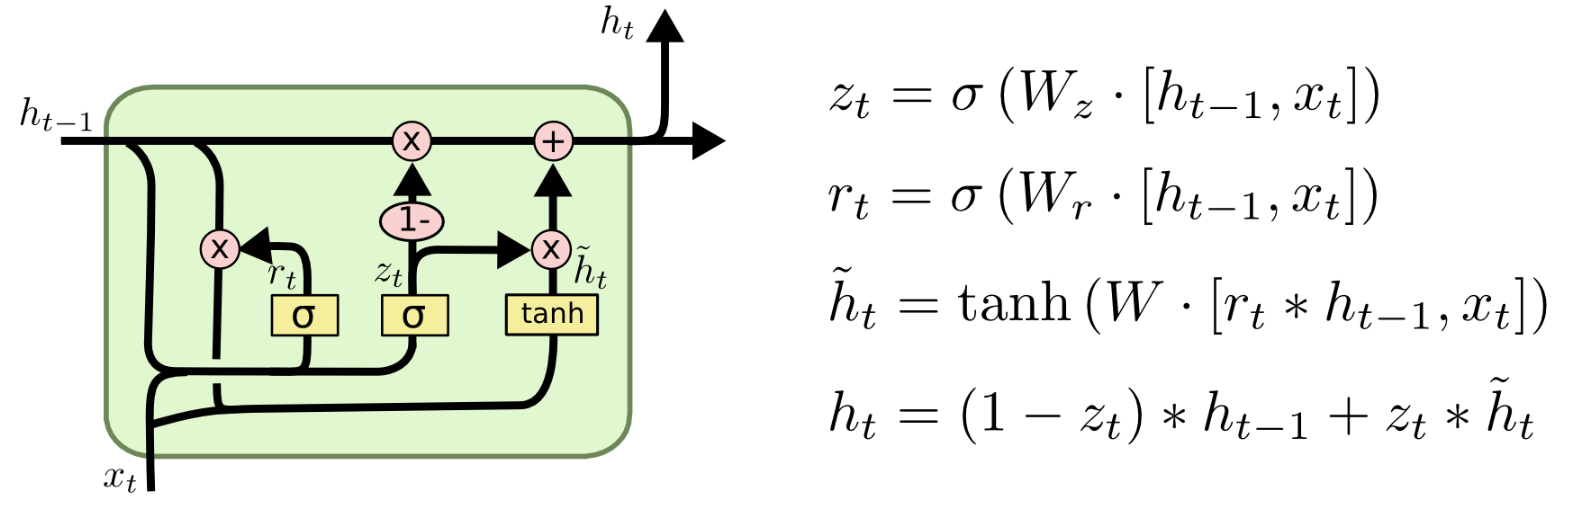

This image has been taken from the excellent blog post by Christopher Olah where you can find more details on the subject. To resume,  htht  stands for the output at time  tt  (i.e.  tt th data point being seen by the network),  xtxt  is the input and  ht−1ht−1  is the output from the previous step. We see here that the layer performs a sequence of operations which we won't get into. What we must keep in mind is that these operations keep memory of the previous data seen.

The final layer will be an output layer which will be a simple linear layer.

Create a class MyRNN which inherits from nn.module
The __init__ function will take variables in_size , hidden_size, out_size.
Call the first layer input_layerand it will an embedding layer . This can be done by using the Embedding layer from torch.nn.
Call the second layer hidden_layer and make it a GRU layer.
Call the final layer output_layer and make it a linear layer.
   The consistency between the sizes of the output of one layer and the input to the next layer is left as an exercise. In return, some helper functions have been provided.

In [ ]:
class MyRNN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.input_layer = nn.Embedding(in_size, hidden_size)
        self.hidden_layer = nn.GRU(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, out_size)
        
        
    def forward(self, input_data, hidden_data):
        input_data = self.input_layer(input_data.view(1,-1))
        output_data, hidden_data = self.hidden_layer(input_data.view(1,1,-1), hidden_data)
        output_data = self.output_layer(output_data.view(1,-1))
        return output_data, hidden_data
    
    def initialize_hidden_params(self):
        # This is a convenience function given to set the hidden state to all zeros in the beginning.
        # Doesn't affect the actual hidden layer weights
        return Variable(torch.zeros(1, 1, self.hidden_size))

Once the network has been created, (well not yet since we haven't created an instance of the MyRNN object), we must think about the variables in_size, hidden_size and out_size. To make matters simple, we will use the same number for all these variables and take it to be the number of characters that we can have. Remember that we stored this number in the variable n_chars.

Create an instance of the object MyRNN and call it first_rnn. Initialize it with all the necessary variables set to n_chars

In [ ]:
first_rnn = MyRNN(in_size=n_chars, hidden_size=n_chars, out_size=n_chars)

Luke, Remember your training 
We are now ready to start training our network. Up to this point, we haven't done much which is specific to RNNs. It is the training procedure which will be make the RNN special. As was mentioned at the beginning of the module, the output from the RNN is fed back to it. This process is repeated for a certain number of times. In our case, this will be repeated for a number of steps equal to the batch size. In other words, the network will keep track of 25 characters at a time. This might seem low, but we are free to choose larger batch sizes (since it is a hyperparameter).

During these 25 steps, however, the losses will not be backpropagated. In fact, we accumulate the losses and the gradients during these 25 steps. The backpropagation step happens only after the completion of these 25 steps.

Thus one training step for an RNN can be described via the following steps:

1 - Set the gradients of the network to zero.
2 - For number of steps equal to the batch size do:
Compute the output from the network.
Compute the loss and add this to the loss from the previous step
3 - Propagate the loss back through the network.

Notice that this is different from the training procedure for convolutional networks we saw in the previous module, where the error after each data point was backpropagated.

Before we proceed, we need to choose an adapted loss function and also an optimizer. The choice for the loss function is dictated by the type of problem. In our case, we can think of our problem as a classification/prediction problem (even though it is strictly not) since we need to compare the output of the network with any one of the characters in all_characters. So, we must predict the class to which the output belongs. The adapted choice is then the Cross-Entropy Loss. You can see the documentation here https://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss

We are now left with the choice of the optimization algorithm. We will be using the Adam optimizer.https://arxiv.org/abs/1412.6980.  Adam stands for adaptive moment estimation. In practice, rather than simply computing the noisy gradient at each time-step like in SGD, it keeps track of the previous gradients via an exponential moving average and has two other parameters which determine the decay of the mean and variance of the gradients. It is a robust optimizer and used rather frequently in academia and industry.

Define the learning rate as learning_rate and set it to 0.05
Define an object optimizer_rnn which is an optimizer object from torch.optim. Use Adam rather than SGD

In [ ]:
learning_rate = 0.005
optimizer_rnn = torch.optim.Adam(first_rnn.parameters(), lr = learning_rate)

We will now encapsulate the training in a function called trainer_rnn. Remember that since we must accumulate the losses for a certain number of steps, we can't directly use the trainer_generic function from utils.py. We must define our own.

Define a function trainer_rnn which takes model, input_data, out_expected as arguments. model stands for the network we want to train, input_data for the input data, and out_expected is the expected output.
The function must perform the following steps in order
- Set the gradients of model to zero.
- Create a variable loss_function which will be the CrossEntropyLoss from the nn module.
- Create a variable loss and set it to zero. We will accumulate the loss in this variable
- For each entry or character in batch_size, store the output of the model in the variables out_rnn and hidden_params.
- Compute the loss by using the loss_function with the arguments out_rnn and the current entry of out_expected.
- Add this loss to the variable loss
- Outside the loop, propagate the loss backwards through the network via backpropagation.
Some bits of the function have been provided already

In [ ]:
def trainer_rnn(model, input_data, out_expected, batch_size=25):
    hidden_params = model.initialize_hidden_params()
    model.zero_grad()
    loss_function = nn.CrossEntropyLoss()
    loss = 0.0
    for char in range(batch_size):
        out_rnn, hidden_params = model(input_data[char], hidden_params)
        loss = loss + loss_function(out_rnn, out_expected[char].view(1))
    loss.backward()
    optimizer_rnn.step()
    return loss.data.item()/batch_size

We are in the end game now: we can run the training for a certain number of epochs, and evaluate how the network performs. But a question still lingers: How can we be sure that our network learnt how to write Sherlock Holmes stories. To this end, we have provided an evaluate_rnn function which evaluates the performance of the network by generating a sequence of characters given some initial condition. The hope then is that as training progresses, the text generated will seem more and more Sherlock-like.

- Set n_epochs to 40
- Create a loop over n_epochs. Within the loop, create batches using make_batches_new.

For each batch generated:
- Pass each batch to the function trainer_rnn. Remember that the function trainer_rnn returns the loss for that batch
- Store the loss returned after training in a variable epoch_loss.
Print the average loss during the epoch, by dividing epoch_loss by the size of initial_tensor.
Using the function generate_samples from the file utils_rnn.py, generate some text at the end of each epoch. You can use 'I' as a starting character, and can generate a text of length 100.
For rapid results, you can use only the first 10000 characters in the corpus.
 
 Remember that you can understand the signature and query the documentation of the function function_name by writing ?function_name  in a cell.

In [ ]:
from utils_rnn import *
n_epochs = 40
for epoch in range(n_epochs):
    batches = make_batches_new(initial_tensor[:10000], final_tensor[:10000], batch_size)
    epoch_loss = 0
    for x, y in batches:
        loss = trainer_rnn(first_rnn,x,y)    
        epoch_loss += loss
    
    epoch_loss = epoch_loss/initial_tensor[:10000].shape[0]
    print("Epoch:", epoch, " Epoch loss:", epoch_loss )
    print(generate_samples(first_rnn, start_char='I', sample_length=100))

In [ ]:
"""
Epoch: 0  Epoch loss: 0.09877232504272455
I gfrrth difth!" At wh no my, Hing sigh chal" angregcalling "pits neverot reantal. Won Don keking ror
Epoch: 1  Epoch loss: 0.08615066790771483
I es as you preaclow bexbeos to an pndare pisch mot a ben," ner dordect mut?" I aldre a temilt is he 
Epoch: 2  Epoch loss: 0.08135611928558349
Iged acctlolfough yo dictlee. "Lo. How youg He o seetlock wittlle ge seetolederomes. How ho'd ist kev
Epoch: 3  Epoch loss: 0.07797839942932126
It it himsin," "seo-dicc-I kncorcifollre saibllloref ges heve dimlized the nale fo domfolloveris nowt
................
Epoch: 31  Epoch loss: 0.056814470497131335
I med at coat-co-lloodgely the vezantorrating to his fro despecenticallly-griver ble baston, inted or
.................
"""

So there you are. You have successfully trained a neural network to write text like Sir Arthur Conan Doyle. Even though the length of text we sample is quite small, we can nevertheless remark some interesting features of the generated text. For instance, the network learns some basic words like and, of you and could quite quickly into training. Furthermore, it also learns some basic grammatical rules: closing the quotation marks once they have been opened, putting question works if sentences begin with question words like what, where. The system isn't perfect but given that we fed the network simple characters, it is remarkable that the network is able to learn these long-term dependencies.

A few final remarks are in order

1 - This exercise was rather different from the previous exercises since we didnt classify or learn some features from given data. Rather, we inferred a probability distribution over the set of characters, and then sampled from the probability distribution via a markov chain. Thus, we understand that neural networks are useful not only for classifying data but also for generating data

2 - The batch size and the learning rate are hyper-parameters, and probably the most important hyperparameters of all. The training and the sampling steps depend on them quite strongly. As you can observe, the generated text of length 100 might not be too useful if we set the batch size to 25. This is because a batch_size of 25 simply means that the hidden layer in the RNN contains the memory of only 25 characters at a time. For a faithful generation of text, we should definitely increase this batch size.

3 - The learning rate is very important during training. If we have a very high learning rate in the beginning, we might get stuck in some local minima not too representative of the training set. Too low and the training becomes slow. There is however no golden rule for setting the learning rate. We can however run many instances of our network and compare the rates at which the network learns. Or, we could have an adaptive learning rate such that it changes according to some deterministic rule. We shall see how to do this in the following module.

# - B - Luke, Adapt your training 
## Maybe it's not so elementary after all
In the previous module, we understood how RNNs could be used to generate text using Markov chains. In this case, RNNs are used to infer transition probabilities between two characters. Once training has been done, we use these probabilities to sample characters and hence generate text.

Nevertheless, we could make some improvements to the process. This is done by tweaking two critical hyper-parameters: batch size and the learning rate. There is another hyper-parameter which we didn't touch upon: the number of layers in the Gated Recurrent Unit (GRU) used to build up the hidden state for the RNN. The steps to be followed are the same as in the last module. Barring some help, you are on your own.

Basic imports 
As always, we start with the imports

Import torch
From the module torch.autograd import Variable
Import the module torch.nn and name it `nn

In [ ]:
import torch 
from torch.autograd import Variable
import torch.nn as nn

We will now load the data provided in the file holmes_clean.txt from the data/module_4 folder.

Load the text in the file holmes_clean.txt into a variable all_text

In [ ]:
holmes_text = open('data/module_4/holmes_clean.txt', 'r')
all_text = holmes_text.read()
holmes_text.close()

Some of the functions written during the last module are provided here in the file utils_rnn2.py.

Import the file utils_rnn2.py
Using the function char2tensor create two tensors initial_tensor and final_tensor storing respectively:
- Text starting from the first character to the next to last character
- Text starting from the second character to the last character

In [ ]:
from utils_rnn2 import *

initial_tensor = char2tensor(all_text[:-1])
final_tensor = char2tensor(all_text[1:])

We have also provided the function make_batches_new function for making batches. In what follows, we will be playing around with the batch sizes.

- Define two variables bat_size_100 and bat_size_200
- Set them respectively to 100 and 200

These are the three batch sizes that we will be playing around with, and finally compare their effect on the network's performance

In [ ]:
bat_size_100 = 100
bat_size_200 = 200

## A deeper network 
We will now create our network, but with a variable number of layers for the GRU cell. Since, we have become experts in writing classes for encapsulating our networks, very little help will be provided for this step.

Create a class MyRNN .
The __init__ function now takes 4 arguments: in_size, hidden_size, out_size and num_layers.
In the __init__ function, you must also create two class variables hidden_size and num_layers, which will be initialized to hidden_size and num_layers passed as argument to the __init__ function
The variable num_layers has to be passed to the nn.GRU layer.

In [ ]:
class MyRNN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size,num_layers):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.input_layer = nn.Embedding(in_size, hidden_size)
        self.hidden_layer = nn.GRU(hidden_size, hidden_size,num_layers)
        self.output_layer = nn.Linear(hidden_size, out_size)
        
        
    def forward(self, input_data, hidden_data):
        input_data = self.input_layer(input_data.view(1,-1))
        output_data, hidden_data = self.hidden_layer(input_data.view(1,1,-1), hidden_data)
        output_data = self.output_layer(output_data.view(1,-1))
        return output_data, hidden_data
    
    def initialize_hidden_params(self):
        return Variable(torch.zeros(self.num_layers, 1, self.hidden_size))

Did you notice something ? We made our network deeper by simply adding more layers to the GRU. Neat isn't it?

We will now create two networks rnn_100 and rnn_200, which will be trained with different batch sizes. These will be constructed in exactly the same manner, with the difference occurring during training.

- Create two networks rnn_100 and rnn_200.
- Figuring out the values of the variables in_size, hidden_size and out_size is left as a challenge.
- Set the number of layers for both networks to 2.

In [ ]:
n_chars = len(all_chars)
num_layers = 2
rnn_100 = MyRNN(in_size=n_chars, hidden_size=n_chars, out_size=n_chars, num_layers=num_layers)
rnn_200 = MyRNN(in_size=n_chars, hidden_size=n_chars, out_size=n_chars, num_layers=num_layers)

Define a variable learning_rate and set it to 0.05
Define two optimizer objects optimizer_100 and optimizer_200.
The two optimizers will use ADAM as the algorithm for the training.

   Remember that the two optimizers will work on two different networks. Thus, the parameters passed to these optimizers should be set accordingly

In [ ]:
learning_rate = 0.05
optimizer_100 = torch.optim.Adam(rnn_100.parameters(), lr = learning_rate)
optimizer_200 = torch.optim.Adam(rnn_200.parameters(), lr = learning_rate)

## Sampling text 
We are almost set to train our networks. The trainer_rnn function has once again been provided in the utils_rnn2.py, except that we have added an extra variable optimizer since we have different optimizers for different networks.

Before we begin training, we need to sample the text as well, and this is what we will be writing here now.

Create a model temp_rnn and initialize it as the other models.
Declare a variable hidden_params which is given by the initalize_hidden_params function of temp_rnn.

In [ ]:
temp_rnn = MyRNN(in_size=n_chars, hidden_size=n_chars, out_size=n_chars, num_layers=num_layers)
hidden_params = temp_rnn.initialize_hidden_params()

Set start_char to 'I'
Declare a start_tensor which stores the tensor representation of start_char
Set the variable predicted_text to start_char
We must initialize the hidden state by passing the start_tensor and hidden_params to temp_rnn. This returns two variables which we call output_params and hidden_params.

Create temp_input to store the tensor representations of the sampled characters. Initialize this to the first element of start_tensor

In [ ]:
start_char = 'I'
start_tensor = char2tensor(start_char)
predicted_text = start_char
output_params, hidden_params = temp_rnn(start_tensor, hidden_params)
temp_input = start_tensor[0]

For the sampling step, we have to perform a loop over sample_length. Let us note all the steps to be performed in one pass of the loop

We pass temp_input and hidden_params to temp_rnn. This returns output_params and hidden_params.
The output_params have to be converted into probabilities. This is done via the following transformation:

f(x)=exp(βx)

 
Since output_params is a Variable, we will not perform the transformation on output_params itself, but only on the data stored in output_params. Furthermore, to assure that we have the right shape of the resulting tensor, we use the view function with the argument -1 which returns a tensor of the correct shape.

Perform steps 1 keeping the same variable names.
Create a variable temp_sample_probs using the attribute data and function view on output_params. You can do the two steps in one line (by chaining the operations) or on two lines.

In [ ]:
output_params, hidden_params = temp_rnn(temp_input, hidden_params)
temp_sample_probs = output_params.data.view(-1)

Declare beta and set it to 1.0
Once we have temp_sample_probs, we will perform the transformation above using the functions mul (with beta as argument) and exp. Remember that we must first multiply by beta and then perform the exponentiation.

In [ ]:
beta = 1.0
temp_sample_probs = temp_sample_probs.mul(beta).exp()

temp_sample_probs have to be normalized.

Declare a new variable sample_probs by dividing temp_sample_probs by the sum of all terms in temp_sample_probs.
Print the sum of all terms in sample_probs using the sum function

In [ ]:
sample_probs = temp_sample_probs.div(temp_sample_probs.sum())
print(sample_probs.sum())
# -> tensor(1.0000)

We finally have the transition probabilities, we can now sample from them. To this end, we use the function multinomial from the torch library. We must pass the probability distribution and the number of samples to be generated.

Generate one sample from multinomial with sample_probs as the input tensor and set num_samples to 1. Name this sample sample_index. We need the first element of the tensor returned by multinomial
Convert sample_index into a character sample_char by getting the corresponding character from all_chars
Print sample_char

In [ ]:
sample_index = torch.multinomial(sample_probs, num_samples=1)[0]
sample_char = all_chars[sample_index]
print(sample_char)
# -> g

Now that we have one character generated, we will repeat the steps above in a loop. But before that, we must add the generated character to the text we started off

Add sample_char to predicted_text
Print predicted_text
Update temp_input to a new tensor corresponding to sample_char using the function char2tensor.

In [ ]:
predicted_text += sample_char
print(predicted_text)
temp_input = char2tensor(sample_char)
# -> Ig

Bravo ! Now that we know all these steps, we can simply encapsulate them in a function called generate_samples.

Write a function generate_samples which performs all the steps above. The arguments to this function are model, start_char, sample_length and beta.
Set beta to 1.0
Check that the function works by testing it on temp_rnn

In [ ]:
def generate_samples(model, start_char, sample_length, beta = 1.0):
    hidden_params = model.initialize_hidden_params()
    start_tensor = char2tensor(start_char)
    predicted_text = start_char
    output_params, hidden_params = model(start_tensor[0], hidden_params)
    temp_input = start_tensor[0]
    
    for i in range(sample_length):
        output_params, hidden_params = model(temp_input, hidden_params)
        temp_sample_probs = output_params.data.view(-1)
        temp_sample_probs = temp_sample_probs.mul(beta).exp()
        
        sample_probs = temp_sample_probs.div(temp_sample_probs.sum())
        
        sample_index = torch.multinomial(temp_sample_probs, num_samples=1)[0]
        
        sample_char = all_chars[sample_index]
        predicted_text += sample_char
        temp_input = char2tensor(sample_char)

    return predicted_text

generate_samples(temp_rnn, start_char='I', sample_length=100)

# -> 'InB\t_|2zdN2iR&#acLR;h,v[GJxI\'A!rV.\t|U`zu9Z!6\x0b#p221\nN_KEPe8wJo?6J[>4vL\x0c1?(LEK_JGsBQR[<3]Hl{n"uC`r\r-InZ'

## Let the training... begin 
Everything we require is in place now. We must now train these networks. We will train both networks rnn_100 and rnn_200 together.

Create two lists epoch_loss_100 and epoch_loss_200. These two lists will store the losses after each epoch for the two networks respectively.

Create a variable num_epochs to 100.

Write a loop over num_epochs and perform the training of the two networks. At the end of each epoch, sample text of length 100 from the two networks. Append the losses for both networks to the corresponding lists.

To check your work, you may perform training over the first 50000 characters in the corpus

In [ ]:
epoch_loss_100 = []
epoch_loss_200 = []
num_epochs = 100

for i in range(num_epochs):
    batches_100 = make_batches_new(initial_tensor[:50000], final_tensor[:50000], batch_size=100)
    epoch_loss = 0
    for x,y in batches_100:
        loss = trainer_rnn(rnn_100, optimizer_100, x,y)
        epoch_loss += loss
    epoch_loss /= 50000
    epoch_loss_100.append(epoch_loss)
    print(epoch_loss)
    print(generate_samples(rnn_100, start_char='I', sample_length=100))

for i in range(num_epochs):
    batches_200 = make_batches_new(initial_tensor[:50000], final_tensor[:50000], batch_size=200)
    epoch_loss = 0
    for x,y in batches_200:
        loss = trainer_rnn(rnn_200, optimizer_200, x,y)
        epoch_loss += loss
    epoch_loss /= 50000
    epoch_loss_200.append(epoch_loss)
    print(epoch_loss)
    print(generate_samples(rnn_200, start_char='I', sample_length=100))

In [ ]:
"""
0.035123799407958955
I alsan ialependizahsn t tpe als s wlan t 
medpen t mhloiw ooe wed hl?tomtattin u aps lhnin ses an p 
0.03498309873962401
Ivss ."s dss ,e"
?r
, e hsne? ey ene de h ds
 vhes v
 e""
"  ddse
"s
 d hee  s h -"sss nnBs"  add"s?"
 ......................
 
"""

Hmmm... we notice that even though the losses are small, the sampled text isn't quite good. This is where the learning rate comes into play. As you might remember, we took a smaller learning rate in the previous module. Before moving forward, lets plot the losses after each epoch and compare the dependence on the batch size

Import matplotlib.pyplot and rename it as plt
Import the library seaborn

Run the command
%matplotlib inline

This last command allows us to preview the plots within a notebook cell.

Using the plot function from plt, plot the lists epoch_loss_100 and epoch_loss_200.

In [ ]:
import matplotlib.pyplot as plt 
import seaborn 
%matplotlib inline

plt.plot(epoch_loss_100)
plt.plot(epoch_loss_200)

Perhaps reducing the learning rate might make things better. Since we might need to stop and check the training, it will be better to encapsulate everything in a function.

- Create a function learning which takes as arguments model, optimizer batch_size, num_epochs, initial_tensor and final_tensor. initial_tensor and final_tensor can be set bt default to the first 10000 characters.
- The function will return a list epoch_loss_list storing the losses after each epoch.
- Set learning_rate to 0.005
- Redefine optimizer_100 and optimizer_200 with this new learning rate.
Before we redefine the new optimizers, we must first re-initialize the networks. This can be done by simply redeclaring rnn_100 and rnn_200 as was done earlier.

In [ ]:
def learning(model, optimizer, batch_size, num_epochs, initial_tensor = initial_tensor[:10000], final_tensor=final_tensor[:10000]):
    epoch_loss_list = []
    for i in range(num_epochs):
        batches = make_batches_new(initial_tensor, final_tensor, batch_size=batch_size)
        epoch_loss = 0
        for x,y in batches:
            loss = trainer_rnn(model, optimizer, x,y)
            epoch_loss += loss
        epoch_loss /= initial_tensor.shape[0]
        epoch_loss_list.append(epoch_loss)
        print(epoch_loss)
        print(generate_samples(model, start_char='I', sample_length=100))
    return epoch_loss_list

rnn_100 = MyRNN(in_size=n_chars, hidden_size=n_chars, out_size=n_chars, num_layers=num_layers)
rnn_200 = MyRNN(in_size=n_chars, hidden_size=n_chars, out_size=n_chars, num_layers=num_layers)

learning_rate = 0.005
optimizer_100 = torch.optim.Adam(rnn_100.parameters(), lr=learning_rate)
optimizer_200 = torch.optim.Adam(rnn_200.parameters(), lr=learning_rate)

Initalize the lists epoch_list_100_bis and epoch_list_200_bis to empty lists
Rerun the training for 100 epochs using the function learning

In [ ]:
epoch_list_100_bis = []
epoch_list_200_bis = []

epoch_list_100_bis = learning(rnn_100, optimizer_100, batch_size=100, num_epochs=100)

epoch_list_200_bis = learning(rnn_200, optimizer_200, batch_size=200, num_epochs=50)

Plot the losses during training for the two batch sizes

In [ ]:
# plt.plot(epoch_list_100_bis, 'r')

plt.plot(epoch_list_200_bis, 'b')

We note that the loss for the batch size of 200 reduces fairly quickly. Remark however that after a certain number of epochs, the samples begin with complete phrases such as In the year 1878. For the smaller batch size case, things aren't too clear: the loss reduces but the sampling isnt great. We do have one last trick up our sleeves. And that is by adapting the learning rate during training.

## Follow a routine 
Having a fixed learning rate isn't useful since it doesn't allow for flexibility during training. As we observed, a learning rate which is too high leads to poor results, a learning rate too low leads to glacial progress. As master Yoda would say, we must bring balance. Fortunately for us, torch already has a scheduler to schedule changes in the learning rate during training.

This functionality is found in the optim module under the name lr_scheduler

Import lr_scheduler from optim

In [ ]:
from torch.optim import lr_scheduler

Many scheduling schemes are provided. The simplest one is StepLR which reduces the learning rate by a certain amount after a fixed number of epochs. For instance over 100 epochs, we can decide to reduce the initial learning rate by 10 after every 20 epochs. So if we begin with a learning rate of 0.1, at the end of 100 epochs we would end up with a learning rate  10−510−5 . This is the method we will use here. Other methods like exponential decay are also provided.

Set the learning rate to 0.05
Create a scheduler named scheduler_rnn of the StepLR type. Set step_size to 10 and set gamma to 0.2.
This means that after every 10 epochs, we will reduce the initial learning rate by 5. Of course, these are again hyperparameters which need to be fine-tuned further.

Once again, don't forget to reinitialize the network rnn_200 and the corresponding optimizer optimizer_200. Use the standard SGD algorithm for optimization.

In [ ]:
learning_rate = 0.05
rnn_200 = MyRNN(in_size=n_chars, hidden_size=n_chars, out_size=n_chars, num_layers=num_layers)

optimizer_200 = torch.optim.SGD(rnn_200.parameters(), lr=learning_rate)
scheduler_rnn = lr_scheduler.StepLR(optimizer_200, step_size=10, gamma=0.2)

Implementing the scheduler in code is straightforward. All that we need to do at the beginning of every epoch is to perform the scheduler step i.e. internally the scheduler checks whether it needs to reduce the learning rate. If it does, then it reduces the learning rate according to the chosen rule, otherwise it passes on to the next step of the loop.

Write a new function learning2 with the same arguments as learning.
Add where appropriate, the update for the learning rate according to the chosen schedule

In [ ]:
def learning2(model, optimizer, batch_size, num_epochs, initial_tensor = initial_tensor[:10000], final_tensor=final_tensor[:10000]):
    epoch_loss_list = []
    for i in range(num_epochs):
        scheduler_rnn.step()
        batches = make_batches_new(initial_tensor, final_tensor, batch_size=batch_size)
        epoch_loss = 0
        for x,y in batches:
            loss = trainer_rnn(model, optimizer, x,y)
            epoch_loss += loss
        epoch_loss /= initial_tensor.shape[0]
        epoch_loss_list.append(epoch_loss)
        print(i, epoch_loss)
        print(generate_samples(model, start_char='I', sample_length=100))
    return epoch_loss_list

Now we can pass to the training step.

Define a list epoch_loss_200_final which will store the results (losses) from the training
Use the function learning2 to train the network rnn_200

In [ ]:
epoch_loss_200_final = learning2(rnn_200, optimizer_200, batch_size=200, num_epochs=100)

So what's happening? Well, it turns out that even though the learning rate is being reduced via some deterministic rule, the sampling isn't too good. Multiple reasons could be behind this:

Sensitivity on the initial learning rate. The initial learning rate determines the kinds of minima that the optimizer finds. If in the beginning we find good minima, then it's good otherwise we can be stuck in some undesirable minima.

It is also possible that we are changing the learning rate too quickly and that doesn't allow the network to stabilize. We could try changing the learning rate only so often.

SGD is perhaps not a well-suited algorithm since it doesn't take into account the cumulated gradients like Adam does. We could try a combination of scheduling and Adam.

All in all, there is no easy way of solving these problems. One must proceed by trial and error, since there doesn't exist a coherent theoretical framework which would determine any of these choices. That can be a downside, but the advantage is that it opens up a large space of opportunities to do some creative work. So, we shouldn't be afraid of going forward boldly and trying different things out!